In [1]:
import logging
import os
import sys
from pathlib import Path
from typing import List, Optional

import IPython
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import textalloc as ta
from tqdm import tqdm

NOTEBOOK_PATH: Path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
PROJECT_DIR: Path = NOTEBOOK_PATH.parent.parent
sys.path.append(str(PROJECT_DIR))
import src.utils.custom_log as custom_log
import src.utils.injury_limits as injury_limits
from src._StandardNames import StandardNames
from src.utils.ParquetHandler import ParquetHandler
from src.utils.PathChecker import PathChecker
from src.utils.set_rcparams import set_rcparams

# logging
LOG: logging.Logger = logging.getLogger(__name__)
custom_log.init_logger(log_lvl=logging.INFO)
LOG.info("Log initialized")

# working dir
os.chdir(PROJECT_DIR)
LOG.info("Working directory: %s", os.getcwd())

# set plot style
set_rcparams()

2024-08-26 20:33:32,618     INFO  MainProcess  MainThread Log initialized
2024-08-26 20:33:32,623     INFO  MainProcess  MainThread Working directory: /root/py_projects/aihiii
2024-08-26 20:33:32,627     INFO  MainProcess  MainThread Setting rcparams for matplotlib
2024-08-26 20:33:32,658     INFO  MainProcess  MainThread Using style src/visualization/dissertation.mplstyle


In [2]:
STR: StandardNames = StandardNames()

check = PathChecker()
DATA_DIR_VI: Path = check.check_directory(path=PROJECT_DIR / "data" / "doe" / "virthuman")
CHANNELS_FPATH_VI: Path = check.check_file(path=DATA_DIR_VI / STR.fname_channels)
INJ_FPATH_VI: Path = check.check_file(path=DATA_DIR_VI / STR.fname_injury_crit)
DOE_PATH_VI: Path = check.check_file(path=DATA_DIR_VI / "doe.parquet")

DATA_DIR_HIII: Path = check.check_directory(path=PROJECT_DIR / "data" / "doe" / "doe_big_grid_20230922_154140")
CHANNELS_FPATH_HIII: Path = check.check_file(path=DATA_DIR_HIII / STR.fname_channels)
INJ_FPATH_HIII: Path = check.check_file(path=DATA_DIR_HIII / STR.fname_injury_crit)
DOE_PATH_HIII: Path = check.check_file(path=DATA_DIR_HIII / "doe.parquet")

figure_dir = PROJECT_DIR / "reports" / "figures" / NOTEBOOK_PATH.stem
figure_dir.mkdir(parents=True, exist_ok=True)
FIGURE_DIR: Path = check.check_directory(path=figure_dir)

del check, figure_dir

2024-08-26 20:33:32,682     INFO  MainProcess  MainThread Directory '/root/py_projects/aihiii/data/doe/virthuman' exists
2024-08-26 20:33:32,684     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/virthuman/channels.parquet' exists
2024-08-26 20:33:32,687     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/virthuman/injury_criteria.parquet' exists
2024-08-26 20:33:32,692     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/virthuman/doe.parquet' exists
2024-08-26 20:33:32,694     INFO  MainProcess  MainThread Directory '/root/py_projects/aihiii/data/doe/doe_big_grid_20230922_154140' exists
2024-08-26 20:33:32,696     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/doe_big_grid_20230922_154140/channels.parquet' exists
2024-08-26 20:33:32,698     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/doe_big_grid_20230922_154140/injury_criteria.parquet' exists
2024-08-26 20:33:32,702    

2024-08-26 20:33:32,754     INFO  MainProcess  MainThread Read /root/py_projects/aihiii/data/doe/virthuman/injury_criteria.parquet
2024-08-26 20:33:32,762     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/virthuman/injury_criteria.parquet' exists
2024-08-26 20:33:32,832     INFO  MainProcess  MainThread Got (243, 13)
2024-08-26 20:33:32,867     INFO  MainProcess  MainThread Plotting
  0%|          | 0/3 [00:00<?, ?it/s]2024-08-26 20:33:51,515     INFO  MainProcess  MainThread Read /root/py_projects/aihiii/data/doe/virthuman/injury_criteria.parquet
2024-08-26 20:33:51,516     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/virthuman/injury_criteria.parquet' exists
2024-08-26 20:33:51,540     INFO  MainProcess  MainThread Got (243, 13)
2024-08-26 20:33:51,587     INFO  MainProcess  MainThread Plotting
2024-08-26 20:34:09,112     INFO  MainProcess  MainThread Store plot to /root/py_projects/aihiii/reports/figures/903_AWARE2ALL_Virthuman_Databa

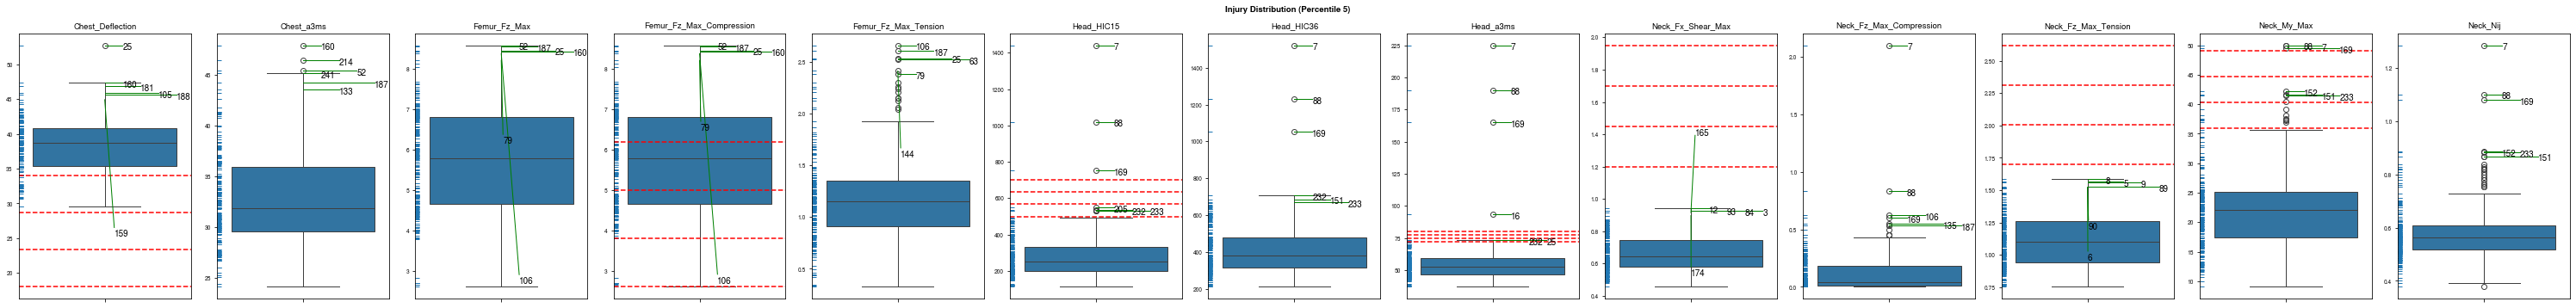

In [3]:
def plot_injury_distribution(percentile: int = 5, store: bool = False):
    LOG.info("Read %s", INJ_FPATH_VI)
    db = ParquetHandler(path=INJ_FPATH_VI).read(percentiles=[percentile])
    LOG.info("Got %s", db.shape)

    lims = injury_limits.get_limits_euro_ncap()

    LOG.info("Plotting")
    fig, ax = plt.subplots(ncols=db.shape[1], figsize=(db.shape[1] * 3.2, 5))
    fig.suptitle(f"Injury Distribution (Percentile {percentile})")
    for i, col in enumerate(sorted(db.columns)):
        sns.rugplot(y=db[col], ax=ax[i])
        sns.boxplot(y=db[col], ax=ax[i])
        if col in lims.columns:
            [ax[i].axhline(y=lims.loc[(pnts, percentile), col], color="r", linestyle="--") for pnts in range(1,5)]

        ax[i].set_title(col)
        ax[i].set_ylabel("")

        nlargest = db[col].nlargest(6)
        ta.allocate(
            ax=ax[i],
            x=[0] * len(nlargest),
            y=nlargest.values,
            text_list=nlargest.index,
            x_scatter=[0] * len(nlargest),
            y_scatter=nlargest.values,
            direction="east",
            min_distance=0.1,
            linecolor="g",
        )

    if store:
        fpath = FIGURE_DIR / f"injury_distribution_{percentile}.png"
        LOG.info("Store plot to %s", fpath)
        plt.savefig(fpath, transparent=False)
        plt.close(fig)


plot_injury_distribution()
_ = [plot_injury_distribution(percentile=p, store=True) for p in tqdm([5, 50, 95])]

In [4]:
def plot_channel(percentile: int = 5, store: bool = False, ids: Optional[List[int]] = None, channels: Optional[List[str]] = None):
    if channels is None:
        channels = [
            "03HEADLOC0OCCUDSXD",
            "03HEADLOC0OCCUDSYD",
            "03HEADLOC0OCCUDSZD",
            "03HEAD0000OCCUACXD",
            "03HEAD0000OCCUACYD",
            "03HEAD0000OCCUACZD",
            "03CHSTLOC0OCCUDSXD",
            "03CHSTLOC0OCCUDSYD",
            "03CHSTLOC0OCCUDSZD",
            "03CHST0000OCCUDSXD",
            "03CHST0000OCCUACXD",
            "03CHST0000OCCUACYD",
            "03CHST0000OCCUACZD",
            "03PELVLOC0OCCUDSXD",
            "03PELVLOC0OCCUDSYD",
            "03PELVLOC0OCCUDSZD",
            "03PELV0000OCCUACXD",
            "03PELV0000OCCUACYD",
            "03PELV0000OCCUACZD",
            "03NECKUP00OCCUFOXD",
            "03NECKUP00OCCUFOZD",
            "03NECKUP00OCCUMOYD",
            "03FEMRRI00OCCUFOZD",
            "03FEMRLE00OCCUFOZD",
        ]

    db = ParquetHandler(path=CHANNELS_FPATH_VI).read(percentiles=[percentile], columns=channels, ids=ids)
    LOG.info("Got %s", db.shape)

    existing_tsps = sorted(db.index.get_level_values(STR.time).unique())
    existing_ids = sorted(db.index.get_level_values(STR.id).unique())

    for channel in db.columns:
        fig, ax = plt.subplots(figsize=(8, 5))
        for idx in existing_ids:
            ax.plot(existing_tsps, db.loc[(slice(None), idx), channel])
        ax.set_title(f"{percentile} Percentile {channel}")
        ax.set_xlabel("Time in [ms]")
        ax.set_ylabel(channel)
        ax.grid()

        if store:
            fpath = FIGURE_DIR / f"channel_{channel}_{percentile}.png"
            LOG.info("Store plot to %s", fpath)
            plt.savefig(fpath, transparent=False)
            plt.close(fig)
        else:
            break


_ = [plot_channel(store=True, percentile=p) for p in tqdm([5, 50, 95])]

  0%|          | 0/3 [00:00<?, ?it/s]2024-08-26 20:35:05,749     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/virthuman/channels.parquet' exists
2024-08-26 20:35:06,137     INFO  MainProcess  MainThread Got (340443, 24)
2024-08-26 20:35:06,591     INFO  MainProcess  MainThread Store plot to /root/py_projects/aihiii/reports/figures/903_AWARE2ALL_Virthuman_Database/channel_03CHSTLOC0OCCUDSXD_5.png
2024-08-26 20:35:08,690     INFO  MainProcess  MainThread Store plot to /root/py_projects/aihiii/reports/figures/903_AWARE2ALL_Virthuman_Database/channel_03HEADLOC0OCCUDSYD_5.png
2024-08-26 20:35:09,826     INFO  MainProcess  MainThread Store plot to /root/py_projects/aihiii/reports/figures/903_AWARE2ALL_Virthuman_Database/channel_03CHST0000OCCUDSXD_5.png
2024-08-26 20:35:11,330     INFO  MainProcess  MainThread Store plot to /root/py_projects/aihiii/reports/figures/903_AWARE2ALL_Virthuman_Database/channel_03CHST0000OCCUACZD_5.png
2024-08-26 20:35:12,490     INFO  MainP

In [5]:
def pairplot_doe(store: bool = False):
    LOG.info("Read %s", DOE_PATH_VI)
    db = ParquetHandler(path=DOE_PATH_VI).read()
    LOG.info("Got %s", db.shape)

    LOG.info("Plotting")
    g = sns.pairplot(db, corner=True)
    g.figure.suptitle(
        f"Full Factorial DOE with {db.shape[1]} Factors in {len(db[db.columns[0]].unique())} Levels = {db.shape[0]} Samples"
    )
    if store:
        fpath = FIGURE_DIR / "pairplot_doe.png"
        LOG.info("Store plot to %s", fpath)
        g.figure.savefig(fpath, transparent=False)
        plt.close(g.figure)


pairplot_doe(store=True)

2024-08-26 20:36:57,440     INFO  MainProcess  MainThread Read /root/py_projects/aihiii/data/doe/virthuman/doe.parquet
2024-08-26 20:36:57,443     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/virthuman/doe.parquet' exists
2024-08-26 20:36:57,456     INFO  MainProcess  MainThread Got (243, 5)
2024-08-26 20:36:57,458     INFO  MainProcess  MainThread Plotting
2024-08-26 20:37:01,187     INFO  MainProcess  MainThread Store plot to /root/py_projects/aihiii/reports/figures/903_AWARE2ALL_Virthuman_Database/pairplot_doe.png


In [6]:
def correlation_plot(store: bool = False, percentile: int = 5):
    LOG.info("Read %s", DOE_PATH_VI)
    doe = ParquetHandler(path=DOE_PATH_VI).read()
    LOG.info("Got %s", doe.shape)

    LOG.info("Read %s", INJ_FPATH_VI)
    inj = ParquetHandler(path=INJ_FPATH_VI).read(percentiles=[percentile])
    LOG.info("Got %s", inj.shape)

    LOG.info("Merge")
    db = pd.merge(doe, inj, left_index=True, right_index=True)
    LOG.info("Got %s", db.shape)

    g = sns.pairplot(db, x_vars=sorted(doe.columns), y_vars=sorted(set(inj.columns)))
    g.figure.suptitle(f"Correlation between DOE and Injury Criteria (Percentile {percentile})")
    g.figure.tight_layout()

    if store:
        fpath = FIGURE_DIR / f"correlation_plot_{percentile}.png"
        LOG.info("Store plot to %s", fpath)
        g.figure.savefig(fpath, transparent=False)
        plt.close(g.figure)


_ = [correlation_plot(percentile=p, store=True) for p in tqdm([5, 50, 95])]

  0%|          | 0/3 [00:00<?, ?it/s]2024-08-26 20:37:03,001     INFO  MainProcess  MainThread Read /root/py_projects/aihiii/data/doe/virthuman/doe.parquet
2024-08-26 20:37:03,002     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/virthuman/doe.parquet' exists
2024-08-26 20:37:03,010     INFO  MainProcess  MainThread Got (243, 5)
2024-08-26 20:37:03,013     INFO  MainProcess  MainThread Read /root/py_projects/aihiii/data/doe/virthuman/injury_criteria.parquet
2024-08-26 20:37:03,014     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/virthuman/injury_criteria.parquet' exists
2024-08-26 20:37:03,035     INFO  MainProcess  MainThread Got (243, 13)
2024-08-26 20:37:03,048     INFO  MainProcess  MainThread Merge
2024-08-26 20:37:03,050     INFO  MainProcess  MainThread Got (243, 18)
2024-08-26 20:37:21,245     INFO  MainProcess  MainThread Store plot to /root/py_projects/aihiii/reports/figures/903_AWARE2ALL_Virthuman_Database/correlation_plot_5.p

In [7]:
def correlation_plot_num(store: bool = False, percentile: int = 5):
    LOG.info("Read %s", DOE_PATH_VI)
    doe = ParquetHandler(path=DOE_PATH_VI).read()
    LOG.info("Got %s", doe.shape)

    LOG.info("Read %s", INJ_FPATH_VI)
    inj = ParquetHandler(path=INJ_FPATH_VI).read(percentiles=[percentile])
    LOG.info("Got %s", inj.shape)

    LOG.info("Merge")
    db = pd.merge(doe, inj, left_index=True, right_index=True)
    LOG.info("Got %s", db.shape)

    cor = db.corr(method="kendall").loc[sorted(doe.columns), sorted(inj.columns)]

    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(cor, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, lw=0.1, ax=ax)
    ax.set_title(f"Kendall Correlation between DOE and Injury Criteria ({percentile}PERC)")

    if store:
        fpath = FIGURE_DIR / f"kendall_correlation_plot_{percentile}.png"
        LOG.info("Store plot to %s", fpath)
        fig.savefig(fpath, transparent=False)
        plt.close(fig.figure)


_ = [correlation_plot_num(percentile=p, store=True) for p in tqdm([5, 50, 95])]

  0%|          | 0/3 [00:00<?, ?it/s]2024-08-26 20:38:11,221     INFO  MainProcess  MainThread Read /root/py_projects/aihiii/data/doe/virthuman/doe.parquet
2024-08-26 20:38:11,223     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/virthuman/doe.parquet' exists
2024-08-26 20:38:11,234     INFO  MainProcess  MainThread Got (243, 5)
2024-08-26 20:38:11,236     INFO  MainProcess  MainThread Read /root/py_projects/aihiii/data/doe/virthuman/injury_criteria.parquet
2024-08-26 20:38:11,237     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/virthuman/injury_criteria.parquet' exists
2024-08-26 20:38:11,252     INFO  MainProcess  MainThread Got (243, 13)
2024-08-26 20:38:11,253     INFO  MainProcess  MainThread Merge
2024-08-26 20:38:11,256     INFO  MainProcess  MainThread Got (243, 18)
2024-08-26 20:38:11,630     INFO  MainProcess  MainThread Store plot to /root/py_projects/aihiii/reports/figures/903_AWARE2ALL_Virthuman_Database/kendall_correlation_

In [8]:
def plot_correlation_vi_vs_hiii(store: bool = False, percentile: int = 5):

    LOG.info("Read %s", DOE_PATH_VI)
    doe_vi = ParquetHandler(path=DOE_PATH_VI).read()
    LOG.info("Got %s", doe_vi.shape)
    parser = pd.DataFrame({c: doe_vi[c].unique() for c in doe_vi.columns}, index=[0, 2, 4])
    parser.index.name = "ConfigID"
    for config_id in parser.index:
        doe_vi.replace({col: {parser.loc[config_id, col]: config_id} for col in parser.columns}, inplace=True)

    LOG.info("Read %s", INJ_FPATH_VI)
    inj_vi = ParquetHandler(path=INJ_FPATH_VI).read(percentiles=[percentile])
    LOG.info("Got %s", inj_vi.shape)

    LOG.info("Merge DOE and Injury Values of VI")
    db_vi = pd.merge(doe_vi, inj_vi, left_index=True, right_index=True)
    db_vi.set_index(doe_vi.columns.to_list(), inplace=True)
    LOG.info("Got %s", db_vi.shape)

    LOG.info("Read %s", DOE_PATH_HIII)
    doe_hiii = (
        ParquetHandler(path=DOE_PATH_HIII)
        .read()
        .set_index(STR.perc, append=True)
        .loc[(slice(None), percentile), :]
        .droplevel(STR.perc)
    )
    doe_hiii.rename(
        columns={
            "PAB_M_Scal": "PABPSCAL",
            "PAB_Vent_T": "PABTVENT",
            "Pulse_Angle": "ALPHA",
            "Pulse_X_Scale": "PSCAL",
            "SLL": "SLL",
        },
        inplace=True,
    )
    LOG.info("Got %s", doe_hiii.shape)
    doe_hiii += 1000
    parser = pd.DataFrame({c: doe_hiii[c].unique() for c in doe_hiii.columns})
    parser.index.name = "ConfigID"
    for config_id in parser.index:
        for col in parser.columns:
            doe_hiii[col] = doe_hiii[col].replace({parser.loc[config_id, col]: config_id})

    helper = ParquetHandler(path=DATA_DIR_HIII / "sim_id_2_id.parquet").read()
    doe_hiii = pd.merge(doe_hiii, helper, left_index=True, right_index=True).drop(columns=STR.perc).set_index(STR.id)
    LOG.info("Got %s", doe_hiii.shape)

    LOG.info("Read %s", INJ_FPATH_HIII)
    inj_hiii = ParquetHandler(path=INJ_FPATH_HIII).read(percentiles=[percentile])
    LOG.info("Got %s", inj_hiii.shape)

    LOG.info("Merge DOE and Injury Values of HIII")
    db_hiii = pd.merge(doe_hiii, inj_hiii, left_index=True, right_index=True)
    db_hiii.set_index(doe_vi.columns.to_list(), inplace=True)
    # db_hiii = db_hiii.loc[db_vi.index, :]
    LOG.info("Got %s", db_hiii.shape)

    LOG.info("Merge VI and HIII")
    db_all = pd.merge(db_vi, db_hiii, suffixes=("_vi", "_hiii"), left_index=True, right_index=True)
    LOG.info("Got %s", db_all.shape)

    del doe_vi, inj_vi, db_vi, doe_hiii, inj_hiii, db_hiii

    g = sns.pairplot(
        db_all,
        x_vars=sorted([c for c in db_all.columns if c.endswith("_vi")]),
        y_vars=sorted([c for c in db_all.columns if c.endswith("_hiii")]),
    )
    g.figure.suptitle(f"Correlation between VI and HIII DOE and Injury Criteria (Percentile {percentile})")
    g.figure.tight_layout()

    if store:
        fpath = FIGURE_DIR / f"correlation_plot_vi_vs_hiii_{percentile}.png"
        LOG.info("Store plot to %s", fpath)
        g.figure.savefig(fpath, transparent=False)
        plt.close(g.figure)


_ = [plot_correlation_vi_vs_hiii(store=True, percentile=p) for p in tqdm([5, 50, 95])]

  0%|          | 0/3 [00:00<?, ?it/s]2024-08-26 20:38:13,904     INFO  MainProcess  MainThread Read /root/py_projects/aihiii/data/doe/virthuman/doe.parquet
2024-08-26 20:38:13,905     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/virthuman/doe.parquet' exists
2024-08-26 20:38:13,931     INFO  MainProcess  MainThread Got (243, 5)
2024-08-26 20:38:13,959     INFO  MainProcess  MainThread Read /root/py_projects/aihiii/data/doe/virthuman/injury_criteria.parquet
2024-08-26 20:38:13,963     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/virthuman/injury_criteria.parquet' exists
2024-08-26 20:38:13,980     INFO  MainProcess  MainThread Got (243, 13)
2024-08-26 20:38:13,982     INFO  MainProcess  MainThread Merge DOE and Injury Values of VI
2024-08-26 20:38:13,987     INFO  MainProcess  MainThread Got (243, 13)
2024-08-26 20:38:13,988     INFO  MainProcess  MainThread Read /root/py_projects/aihiii/data/doe/doe_big_grid_20230922_154140/doe.parquet


In [9]:
def plot_correlation_vi_vs_hiii_num(store: bool = False, percentile: int = 5):

    LOG.info("Read %s", DOE_PATH_VI)
    doe_vi = ParquetHandler(path=DOE_PATH_VI).read()
    LOG.info("Got %s", doe_vi.shape)
    parser = pd.DataFrame({c: doe_vi[c].unique() for c in doe_vi.columns}, index=[0, 2, 4])
    parser.index.name = "ConfigID"
    for config_id in parser.index:
        doe_vi.replace({col: {parser.loc[config_id, col]: config_id} for col in parser.columns}, inplace=True)

    LOG.info("Read %s", INJ_FPATH_VI)
    inj_vi = ParquetHandler(path=INJ_FPATH_VI).read(percentiles=[percentile])
    LOG.info("Got %s", inj_vi.shape)

    LOG.info("Merge DOE and Injury Values of VI")
    db_vi = pd.merge(doe_vi, inj_vi, left_index=True, right_index=True)
    db_vi.set_index(doe_vi.columns.to_list(), inplace=True)
    LOG.info("Got %s", db_vi.shape)

    LOG.info("Read %s", DOE_PATH_HIII)
    doe_hiii = (
        ParquetHandler(path=DOE_PATH_HIII)
        .read()
        .set_index(STR.perc, append=True)
        .loc[(slice(None), percentile), :]
        .droplevel(STR.perc)
    )
    doe_hiii.rename(
        columns={
            "PAB_M_Scal": "PABPSCAL",
            "PAB_Vent_T": "PABTVENT",
            "Pulse_Angle": "ALPHA",
            "Pulse_X_Scale": "PSCAL",
            "SLL": "SLL",
        },
        inplace=True,
    )
    LOG.info("Got %s", doe_hiii.shape)
    doe_hiii += 1000
    parser = pd.DataFrame({c: doe_hiii[c].unique() for c in doe_hiii.columns})
    parser.index.name = "ConfigID"
    for config_id in parser.index:
        for col in parser.columns:
            doe_hiii[col] = doe_hiii[col].replace({parser.loc[config_id, col]: config_id})

    helper = ParquetHandler(path=DATA_DIR_HIII / "sim_id_2_id.parquet").read()
    doe_hiii = pd.merge(doe_hiii, helper, left_index=True, right_index=True).drop(columns=STR.perc).set_index(STR.id)
    LOG.info("Got %s", doe_hiii.shape)

    LOG.info("Read %s", INJ_FPATH_HIII)
    inj_hiii = ParquetHandler(path=INJ_FPATH_HIII).read(percentiles=[percentile])
    LOG.info("Got %s", inj_hiii.shape)

    LOG.info("Merge DOE and Injury Values of HIII")
    db_hiii = pd.merge(doe_hiii, inj_hiii, left_index=True, right_index=True)
    db_hiii.set_index(doe_vi.columns.to_list(), inplace=True)

    LOG.info("Got %s", db_hiii.shape)

    LOG.info("Merge VI and HIII")
    db_all = pd.merge(db_vi, db_hiii, suffixes=("_vi", "_hiii"), left_index=True, right_index=True)
    LOG.info("Got %s", db_all.shape)

    del doe_vi, inj_vi, db_vi, doe_hiii, inj_hiii, db_hiii

    cor = db_all.corr(method="kendall").loc[
        sorted([c for c in db_all.columns if c.endswith("_vi")]),
        sorted([c for c in db_all.columns if c.endswith("_hiii")]),
    ]

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.heatmap(cor, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, lw=0.1, ax=ax)
    ax.set_title(f"Kendall Correlation between VI and HIII DOE and Injury Criteria ({percentile}PERC)")

    if store:
        fpath = FIGURE_DIR / f"kendall_correlation_plot_vi_vs_hiii_{percentile}.png"
        LOG.info("Store plot to %s", fpath)
        fig.savefig(fpath, transparent=False)
        plt.close(fig.figure)


_ = [plot_correlation_vi_vs_hiii_num(store=True, percentile=p) for p in tqdm([5, 50, 95])]

  0%|          | 0/3 [00:00<?, ?it/s]2024-08-26 20:41:23,577     INFO  MainProcess  MainThread Read /root/py_projects/aihiii/data/doe/virthuman/doe.parquet
2024-08-26 20:41:23,578     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/virthuman/doe.parquet' exists
2024-08-26 20:41:23,586     INFO  MainProcess  MainThread Got (243, 5)
2024-08-26 20:41:23,599     INFO  MainProcess  MainThread Read /root/py_projects/aihiii/data/doe/virthuman/injury_criteria.parquet
2024-08-26 20:41:23,601     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/virthuman/injury_criteria.parquet' exists
2024-08-26 20:41:23,620     INFO  MainProcess  MainThread Got (243, 13)
2024-08-26 20:41:23,623     INFO  MainProcess  MainThread Merge DOE and Injury Values of VI
2024-08-26 20:41:23,639     INFO  MainProcess  MainThread Got (243, 13)
2024-08-26 20:41:23,640     INFO  MainProcess  MainThread Read /root/py_projects/aihiii/data/doe/doe_big_grid_20230922_154140/doe.parquet
